In [ ]:
import os
import shutil
import cv2
import mediapipe as mp
import tqdm
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Dataset path in Kaggle
file_path = '/Synthetic ASL Alphabet/'  # Path to Synthetic ASL Alphabet dataset

IMG_HEIGHT, IMG_WIDTH = 32, 32
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 29

TRAIN_DATA_DIR = './Synthetic ASL Alphabet/Train_Alphabet'
TEST_DATA_DIR = './Synthetic ASL Alphabet/Test_Alphabet/' 

# Enable mixed precision and GPU memory growth
tf.keras.mixed_precision.set_global_policy('mixed_float16')

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

print("✅ Setup complete.")


✅ Setup complete.


In [2]:
# Enable mixed precision and GPU memory growth
tf.keras.mixed_precision.set_global_policy('mixed_float16')

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

print("✅ Setup complete.")

✅ Setup complete.


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys
import random
import mediapipe as mp
import math

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True)
IMG_SIZE = 224

data = []
label = []

folders = os.listdir(TRAIN_DATA_DIR)

REAL_DATA_DIR = "./ASL Letters/asl_alphabet_train/asl_alphabet_train/"
REAL_LABELS = [chr(i) for i in range(ord('A'), ord('Z') + 1)] + ["nothing"]

MAX_SAMPLES_PER_CLASS = 750
OVERDRAW_LIMIT = 3000

# ✅ Utility: Normalize landmarks
def normalize_landmarks(landmarks):
    base_x, base_y, base_z = landmarks[0]
    normalized = [(x - base_x, y - base_y, z - base_z) for (x, y, z) in landmarks]
    flat = np.array(normalized).flatten()
    norm = np.linalg.norm(flat)
    return flat / norm if norm != 0 else flat

# ✅ Utility: Pairwise distances
def get_distance_features(landmarks):
    distances = []
    for i in range(len(landmarks)):
        for j in range(i + 1, len(landmarks)):
            xi, yi, zi = landmarks[i]
            xj, yj, zj = landmarks[j]
            dist = math.sqrt((xi - xj) ** 2 + (yi - yj) ** 2 + (zi - zj) ** 2)
            distances.append(dist)
    return distances

# ✅ Utility: Angle between vectors
def get_angle_features(landmarks):
    angles = []
    for i in range(1, len(landmarks) - 1):
        a = np.array(landmarks[i - 1])
        b = np.array(landmarks[i])
        c = np.array(landmarks[i + 1])
        ba = a - b
        bc = c - b
        cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
        angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
        angles.append(np.degrees(angle))
    return angles

# ✅ Feature vector: combine all three
def extract_features(landmarks):
    norm = normalize_landmarks(landmarks)
    dist = get_distance_features(landmarks)
    angle = get_angle_features(landmarks)
    return np.concatenate([norm, dist, angle])

# ✅ REAL DATA
for label_name in tqdm(REAL_LABELS, desc="📥 Collecting real samples"):
    folder_path = os.path.join(REAL_DATA_DIR, label_name)

    if label_name == "nothing":
        placeholder_row = [0.0] * (21 * 3 + 210 + 19)  # landmark(63) + dist(210) + angle(19)
        for _ in range(MAX_SAMPLES_PER_CLASS):
            data.append(placeholder_row)
            label.append("blank")
        tqdm.write(f"🧪 'nothing' → Injected {MAX_SAMPLES_PER_CLASS} synthetic 'blank' samples")
        continue

    if not os.path.exists(folder_path):
        tqdm.write(f"⚠️ Missing folder: {label_name}")
        continue

    files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(files)
    files = files[:OVERDRAW_LIMIT]

    valid_samples = []
    sample_count = 0

    for file in files:
        if sample_count >= OVERDRAW_LIMIT:
            break

        try:
            img = cv2.imread(os.path.join(folder_path, file))
            if img is None:
                continue

            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = hands.process(img_rgb)

            if results.multi_hand_landmarks:
                hand_landmarks = results.multi_hand_landmarks[0]
                landmarks = [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]
                feature_vector = extract_features(landmarks)
                valid_samples.append((feature_vector, label_name))
                sample_count += 1
        except Exception as e:
            tqdm.write(f"⚠️ Error in '{file}': {e}")
            continue

    valid_samples = valid_samples[:MAX_SAMPLES_PER_CLASS]
    for row, label_value in valid_samples:
        data.append(row)
        label.append(label_value)

    tqdm.write(f"✅ {label_name:<10} finalized with {len(valid_samples)} samples")

# ✅ SYNTHETIC/EXTRA
for labels in tqdm(folders, desc="📦 Overall class progress"):
    letter_folders = os.path.join(TRAIN_DATA_DIR, labels)
    sample_count = 0
    img_files = os.listdir(letter_folders)

    for img_file in img_files:
        if sample_count >= 900:
            break

        try:
            img = cv2.imread(os.path.join(letter_folders, img_file))
            if img is None:
                continue

            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = hands.process(img_rgb)

            if results.multi_hand_landmarks:
                hand_landmarks = results.multi_hand_landmarks[0]
                landmarks = [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]
                feature_vector = extract_features(landmarks)
                data.append(feature_vector)
                label.append(labels)
                sample_count += 1
        except Exception as e:
            tqdm.write(f"⚠️ Error: {e}")
            continue

    tqdm.write(f"✅ {labels:<10} collected {sample_count} samples")

# ✅ Save
if data:
    df = pd.DataFrame(data)
    df["label"] = label
    output_path = "./working/hand_landmarks_with_features.csv"
    df.to_csv(output_path, index=False)
    print(f"✅ Saved {len(df)} samples to {output_path}")
else:
    print("⚠️ No valid hand landmarks found. Nothing saved.")



📥 Collecting real samples:   4%|▎         | 1/27 [01:02<27:17, 62.98s/it]

✅ A          finalized with 750 samples


📥 Collecting real samples:   7%|▋         | 2/27 [02:06<26:22, 63.28s/it]

✅ B          finalized with 750 samples


📥 Collecting real samples:  11%|█         | 3/27 [03:15<26:19, 65.82s/it]

✅ C          finalized with 750 samples


📥 Collecting real samples:  15%|█▍        | 4/27 [04:39<27:59, 73.03s/it]

✅ D          finalized with 750 samples


📥 Collecting real samples:  19%|█▊        | 5/27 [06:02<28:06, 76.66s/it]

✅ E          finalized with 750 samples


📥 Collecting real samples:  22%|██▏       | 6/27 [07:31<28:18, 80.86s/it]

✅ F          finalized with 750 samples


📥 Collecting real samples:  26%|██▌       | 7/27 [08:56<27:26, 82.35s/it]

✅ G          finalized with 750 samples


📥 Collecting real samples:  30%|██▉       | 8/27 [10:22<26:23, 83.35s/it]

✅ H          finalized with 750 samples


📥 Collecting real samples:  33%|███▎      | 9/27 [11:48<25:14, 84.12s/it]

✅ I          finalized with 750 samples


📥 Collecting real samples:  37%|███▋      | 10/27 [13:15<24:07, 85.15s/it]

✅ J          finalized with 750 samples


📥 Collecting real samples:  41%|████      | 11/27 [14:44<22:59, 86.23s/it]

✅ K          finalized with 750 samples


📥 Collecting real samples:  44%|████▍     | 12/27 [16:27<22:50, 91.39s/it]

✅ L          finalized with 750 samples


📥 Collecting real samples:  48%|████▊     | 13/27 [18:08<22:00, 94.33s/it]

✅ M          finalized with 750 samples


📥 Collecting real samples:  52%|█████▏    | 14/27 [19:42<20:24, 94.17s/it]

✅ N          finalized with 750 samples


📥 Collecting real samples:  56%|█████▌    | 15/27 [21:05<18:08, 90.70s/it]

✅ O          finalized with 750 samples


📥 Collecting real samples:  59%|█████▉    | 16/27 [22:25<16:02, 87.47s/it]

✅ P          finalized with 750 samples


📥 Collecting real samples:  63%|██████▎   | 17/27 [23:46<14:16, 85.62s/it]

✅ Q          finalized with 750 samples


📥 Collecting real samples:  67%|██████▋   | 18/27 [25:12<12:51, 85.68s/it]

✅ R          finalized with 750 samples


📥 Collecting real samples:  70%|███████   | 19/27 [26:36<11:23, 85.40s/it]

✅ S          finalized with 750 samples


📥 Collecting real samples:  74%|███████▍  | 20/27 [28:14<10:23, 89.13s/it]

✅ T          finalized with 750 samples


📥 Collecting real samples:  78%|███████▊  | 21/27 [30:05<09:32, 95.49s/it]

✅ U          finalized with 750 samples


📥 Collecting real samples:  81%|████████▏ | 22/27 [31:58<08:23, 100.72s/it]

✅ V          finalized with 750 samples


📥 Collecting real samples:  85%|████████▌ | 23/27 [33:48<06:55, 103.76s/it]

✅ W          finalized with 750 samples


📥 Collecting real samples:  89%|████████▉ | 24/27 [35:35<05:14, 104.70s/it]

✅ X          finalized with 750 samples


📥 Collecting real samples:  93%|█████████▎| 25/27 [37:26<03:33, 106.55s/it]

✅ Y          finalized with 750 samples


📥 Collecting real samples: 100%|██████████| 27/27 [39:19<00:00, 87.39s/it] 


✅ Z          finalized with 750 samples
🧪 'nothing' → Injected 750 synthetic 'blank' samples


📦 Overall class progress:   4%|▎         | 1/27 [00:41<17:46, 41.00s/it]

✅ A          collected 865 samples


📦 Overall class progress:   7%|▋         | 2/27 [01:21<16:55, 40.62s/it]

✅ B          collected 847 samples


📦 Overall class progress:  11%|█         | 3/27 [01:49<14:01, 35.06s/it]

✅ Blank      collected 5 samples


📦 Overall class progress:  15%|█▍        | 4/27 [02:31<14:23, 37.54s/it]

✅ C          collected 863 samples


📦 Overall class progress:  19%|█▊        | 5/27 [03:01<12:50, 35.02s/it]

✅ D          collected 820 samples


📦 Overall class progress:  22%|██▏       | 6/27 [03:31<11:38, 33.25s/it]

✅ E          collected 783 samples


📦 Overall class progress:  26%|██▌       | 7/27 [04:02<10:47, 32.36s/it]

✅ F          collected 826 samples


📦 Overall class progress:  30%|██▉       | 8/27 [04:32<10:06, 31.91s/it]

✅ G          collected 883 samples


📦 Overall class progress:  33%|███▎      | 9/27 [05:07<09:50, 32.83s/it]

✅ H          collected 869 samples


📦 Overall class progress:  37%|███▋      | 10/27 [05:47<09:54, 34.98s/it]

✅ I          collected 858 samples


📦 Overall class progress:  41%|████      | 11/27 [06:27<09:42, 36.43s/it]

✅ J          collected 862 samples


📦 Overall class progress:  44%|████▍     | 12/27 [07:08<09:26, 37.75s/it]

✅ K          collected 838 samples


📦 Overall class progress:  48%|████▊     | 13/27 [07:48<08:59, 38.53s/it]

✅ L          collected 825 samples


📦 Overall class progress:  52%|█████▏    | 14/27 [08:27<08:24, 38.78s/it]

✅ M          collected 814 samples


📦 Overall class progress:  56%|█████▌    | 15/27 [09:08<07:52, 39.35s/it]

✅ N          collected 857 samples


📦 Overall class progress:  59%|█████▉    | 16/27 [09:47<07:13, 39.39s/it]

✅ O          collected 844 samples


📦 Overall class progress:  63%|██████▎   | 17/27 [10:27<06:33, 39.31s/it]

✅ P          collected 833 samples


📦 Overall class progress:  67%|██████▋   | 18/27 [11:05<05:52, 39.18s/it]

✅ Q          collected 854 samples


📦 Overall class progress:  70%|███████   | 19/27 [11:45<05:14, 39.30s/it]

✅ R          collected 847 samples


📦 Overall class progress:  74%|███████▍  | 20/27 [12:24<04:33, 39.12s/it]

✅ S          collected 833 samples


📦 Overall class progress:  78%|███████▊  | 21/27 [13:04<03:56, 39.48s/it]

✅ T          collected 871 samples


📦 Overall class progress:  81%|████████▏ | 22/27 [13:45<03:20, 40.02s/it]

✅ U          collected 842 samples


📦 Overall class progress:  85%|████████▌ | 23/27 [14:26<02:40, 40.25s/it]

✅ V          collected 797 samples


📦 Overall class progress:  89%|████████▉ | 24/27 [15:07<02:01, 40.56s/it]

✅ W          collected 840 samples


📦 Overall class progress:  93%|█████████▎| 25/27 [15:48<01:20, 40.48s/it]

✅ X          collected 803 samples


📦 Overall class progress:  96%|█████████▋| 26/27 [16:27<00:40, 40.18s/it]

✅ Y          collected 764 samples


📦 Overall class progress: 100%|██████████| 27/27 [17:07<00:00, 38.05s/it]


✅ Z          collected 772 samples
✅ Saved 41965 samples to ./working/hand_landmarks_with_features.csv


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
import joblib

# Load dataset
df = pd.read_csv("./working/hand_landmarks_with_features.csv")
X = df.drop("label", axis=1).values
y = df["label"]

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Optional: Show label distribution
unique_labels, counts = np.unique(y_encoded, return_counts=True)
print("📊 Class distribution:")
for lbl, cnt in zip(unique_labels, counts):
    print(f"{encoder.inverse_transform([lbl])[0]:<8} → {cnt} samples")

# Save the encoder for inference later
joblib.dump(encoder, "./working/label_encoder.pkl")

# One-hot encode
num_classes = len(np.unique(y_encoded))
y_final = to_categorical(y_encoded, num_classes=num_classes)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_final, test_size=0.3, random_state=43)
print(f"✅ Training data shape: {X_train.shape}")
print(f"✅ Test data shape: {X_test.shape}")


📊 Class distribution:
A        → 1615 samples
B        → 1597 samples
Blank    → 5 samples
C        → 1613 samples
D        → 1570 samples
E        → 1533 samples
F        → 1576 samples
G        → 1633 samples
H        → 1619 samples
I        → 1608 samples
J        → 1612 samples
K        → 1588 samples
L        → 1575 samples
M        → 1564 samples
N        → 1607 samples
O        → 1594 samples
P        → 1583 samples
Q        → 1604 samples
R        → 1597 samples
S        → 1583 samples
T        → 1621 samples
U        → 1592 samples
V        → 1547 samples
W        → 1590 samples
X        → 1553 samples
Y        → 1514 samples
Z        → 1522 samples
blank    → 750 samples
✅ Training data shape: (29375, 292)
✅ Test data shape: (12590, 292)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os

# Define model save path
model_save_dir = './working/models'
os.makedirs(model_save_dir, exist_ok=True)
model_save_path = os.path.join(model_save_dir, 'asl_model.h5')

num_classes = y_train.shape[1]

model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint(
    model_save_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[checkpoint, early_stop],
    verbose=2
)

model.save(model_save_path)
print(f"✅ Model saved to {model_save_path}")

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"🎯 Test accuracy: {test_acc:.2f}")


c:\Users\prajw\Desktop\Projects\Sign Language\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        75,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 28)             │           924 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,164 (465.48 KB)

 Trainable params: 119,164 (465.48 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50

Epoch 1: val_accuracy improved from None to 0.64409, saving model to ./working/models\asl_model.h5


735/735 - 3s - 4ms/step - accuracy: 0.2700 - loss: 3.1533 - val_accuracy: 0.6441 - val_loss: 1.0508
Epoch 2/50

Epoch 2: val_accuracy improved from 0.64409 to 0.82196, saving model to ./working/models\asl_model.h5


735/735 - 2s - 2ms/step - accuracy: 0.6243 - loss: 1.1014 - val_accuracy: 0.8220 - val_loss: 0.5307
Epoch 3/50

Epoch 3: val_accuracy improved from 0.82196 to 0.84374, saving model to ./working/models\asl_model.h5


735/735 - 2s - 3ms/step - accuracy: 0.7213 - loss: 0.8101 - val_accuracy: 0.8437 - val_loss: 0.4692
Epoch 4/50

Epoch 4: val_accuracy improved from 0.84374 to 0.87251, saving model to ./working/models\asl_model.h5


735/735 - 2s - 3ms/step - accuracy: 0.7615 - loss: 0.7068 - val_accuracy: 0.8725 - val_loss: 0.3840
Epoch 5/50

Epoch 5: val_accuracy improved from 0.87251 to 0.89089, saving model to ./working/models\asl_model.h5


735/735 - 2s - 3ms/step - accuracy: 0.7963 - loss: 0.6124 - val_accuracy: 0.8909 - val_loss: 0.3646
Epoch 6/50

Epoch 6: val_accuracy improved from 0.89089 to 0.90230, saving model to ./working/models\asl_model.h5


735/735 - 2s - 3ms/step - accuracy: 0.8139 - loss: 0.5563 - val_accuracy: 0.9023 - val_loss: 0.3412
Epoch 7/50

Epoch 7: val_accuracy did not improve from 0.90230
735/735 - 2s - 2ms/step - accuracy: 0.8237 - loss: 0.5452 - val_accuracy: 0.9006 - val_loss: 0.3291
Epoch 8/50

Epoch 8: val_accuracy improved from 0.90230 to 0.91268, saving model to ./working/models\asl_model.h5


735/735 - 2s - 2ms/step - accuracy: 0.8368 - loss: 0.5104 - val_accuracy: 0.9127 - val_loss: 0.3154
Epoch 9/50

Epoch 9: val_accuracy improved from 0.91268 to 0.91455, saving model to ./working/models\asl_model.h5


735/735 - 2s - 2ms/step - accuracy: 0.8474 - loss: 0.4827 - val_accuracy: 0.9146 - val_loss: 0.2769
Epoch 10/50

Epoch 10: val_accuracy improved from 0.91455 to 0.92170, saving model to ./working/models\asl_model.h5


735/735 - 2s - 2ms/step - accuracy: 0.8469 - loss: 0.4806 - val_accuracy: 0.9217 - val_loss: 0.2948
Epoch 11/50

Epoch 11: val_accuracy did not improve from 0.92170
735/735 - 2s - 2ms/step - accuracy: 0.8554 - loss: 0.4526 - val_accuracy: 0.8955 - val_loss: 0.3281
Epoch 12/50

Epoch 12: val_accuracy improved from 0.92170 to 0.93719, saving model to ./working/models\asl_model.h5


735/735 - 2s - 2ms/step - accuracy: 0.8640 - loss: 0.4370 - val_accuracy: 0.9372 - val_loss: 0.2435
Epoch 13/50

Epoch 13: val_accuracy did not improve from 0.93719
735/735 - 2s - 2ms/step - accuracy: 0.8685 - loss: 0.4294 - val_accuracy: 0.9222 - val_loss: 0.2608
Epoch 14/50

Epoch 14: val_accuracy did not improve from 0.93719
735/735 - 2s - 3ms/step - accuracy: 0.8739 - loss: 0.4082 - val_accuracy: 0.9226 - val_loss: 0.2521
Epoch 15/50

Epoch 15: val_accuracy did not improve from 0.93719
735/735 - 2s - 3ms/step - accuracy: 0.8789 - loss: 0.4040 - val_accuracy: 0.9319 - val_loss: 0.2358
Epoch 16/50

Epoch 16: val_accuracy improved from 0.93719 to 0.94094, saving model to ./working/models\asl_model.h5


735/735 - 2s - 2ms/step - accuracy: 0.8796 - loss: 0.3890 - val_accuracy: 0.9409 - val_loss: 0.2264
Epoch 17/50

Epoch 17: val_accuracy improved from 0.94094 to 0.94740, saving model to ./working/models\asl_model.h5


735/735 - 2s - 2ms/step - accuracy: 0.8807 - loss: 0.3954 - val_accuracy: 0.9474 - val_loss: 0.2213
Epoch 18/50

Epoch 18: val_accuracy did not improve from 0.94740
735/735 - 2s - 2ms/step - accuracy: 0.8841 - loss: 0.3807 - val_accuracy: 0.9394 - val_loss: 0.2279
Epoch 19/50

Epoch 19: val_accuracy did not improve from 0.94740
735/735 - 2s - 2ms/step - accuracy: 0.8850 - loss: 0.3799 - val_accuracy: 0.9357 - val_loss: 0.2274
Epoch 20/50

Epoch 20: val_accuracy improved from 0.94740 to 0.94774, saving model to ./working/models\asl_model.h5


735/735 - 2s - 2ms/step - accuracy: 0.8896 - loss: 0.3652 - val_accuracy: 0.9477 - val_loss: 0.2093
Epoch 21/50

Epoch 21: val_accuracy did not improve from 0.94774
735/735 - 2s - 2ms/step - accuracy: 0.8921 - loss: 0.3558 - val_accuracy: 0.9251 - val_loss: 0.2576
Epoch 22/50

Epoch 22: val_accuracy did not improve from 0.94774
735/735 - 2s - 2ms/step - accuracy: 0.8942 - loss: 0.3546 - val_accuracy: 0.9437 - val_loss: 0.2200
Epoch 23/50

Epoch 23: val_accuracy improved from 0.94774 to 0.94843, saving model to ./working/models\asl_model.h5


735/735 - 2s - 2ms/step - accuracy: 0.8957 - loss: 0.3413 - val_accuracy: 0.9484 - val_loss: 0.1994
Epoch 24/50

Epoch 24: val_accuracy did not improve from 0.94843
735/735 - 2s - 2ms/step - accuracy: 0.9006 - loss: 0.3354 - val_accuracy: 0.9445 - val_loss: 0.2065
Epoch 25/50

Epoch 25: val_accuracy did not improve from 0.94843
735/735 - 2s - 3ms/step - accuracy: 0.9016 - loss: 0.3403 - val_accuracy: 0.9467 - val_loss: 0.2036
Epoch 26/50

Epoch 26: val_accuracy did not improve from 0.94843
735/735 - 2s - 2ms/step - accuracy: 0.8978 - loss: 0.3395 - val_accuracy: 0.9292 - val_loss: 0.2364
Epoch 27/50

Epoch 27: val_accuracy did not improve from 0.94843
735/735 - 2s - 2ms/step - accuracy: 0.9026 - loss: 0.3279 - val_accuracy: 0.9406 - val_loss: 0.2098
Epoch 28/50

Epoch 28: val_accuracy improved from 0.94843 to 0.95404, saving model to ./working/models\asl_model.h5


735/735 - 2s - 2ms/step - accuracy: 0.9063 - loss: 0.3277 - val_accuracy: 0.9540 - val_loss: 0.1771
Epoch 29/50

Epoch 29: val_accuracy did not improve from 0.95404
735/735 - 2s - 2ms/step - accuracy: 0.9062 - loss: 0.3139 - val_accuracy: 0.9471 - val_loss: 0.1958
Epoch 30/50

Epoch 30: val_accuracy did not improve from 0.95404
735/735 - 2s - 2ms/step - accuracy: 0.9070 - loss: 0.3127 - val_accuracy: 0.9496 - val_loss: 0.1855
Epoch 31/50

Epoch 31: val_accuracy did not improve from 0.95404
735/735 - 2s - 2ms/step - accuracy: 0.9009 - loss: 0.3328 - val_accuracy: 0.9505 - val_loss: 0.1890
Epoch 32/50

Epoch 32: val_accuracy did not improve from 0.95404
735/735 - 2s - 3ms/step - accuracy: 0.9043 - loss: 0.3218 - val_accuracy: 0.9425 - val_loss: 0.2145
Epoch 33/50

Epoch 33: val_accuracy did not improve from 0.95404
735/735 - 2s - 2ms/step - accuracy: 0.9106 - loss: 0.2980 - val_accuracy: 0.9532 - val_loss: 0.1752
Epoch 33: early stopping
Restoring model weights from the end of the best e

✅ Model saved to ./working/models\asl_model.h5
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9519 - loss: 0.1836
🎯 Test accuracy: 0.95


In [5]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        75,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 28)             │           924 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 357,498 (1.36 MB)

 Trainable params: 119,164 (465.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 238,334 (931.00 KB)

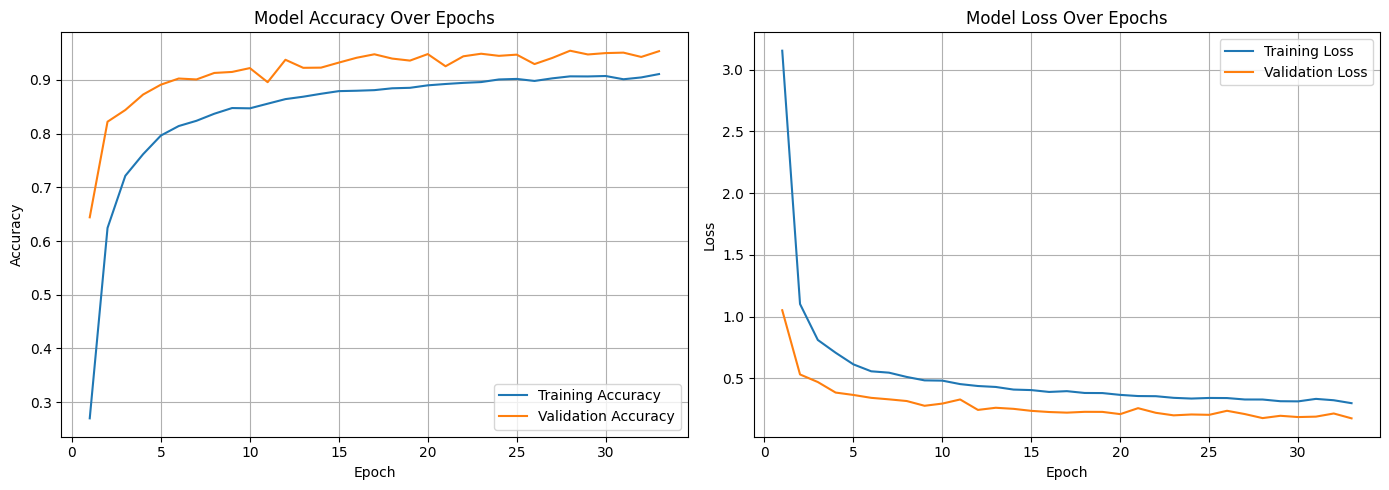

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [8]:
print(os.listdir("./working/models/"))

['asl_model.h5']


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Decode predictions
y_true_labels = encoder.inverse_transform(np.argmax(y_test, axis=1))
y_pred_probs = model.predict(X_test)
y_pred_labels = encoder.inverse_transform(np.argmax(y_pred_probs, axis=1))

# Classification report
report = classification_report(y_true_labels, y_pred_labels, output_dict=True)

# Display per-letter accuracy
print("📊 Per-Letter Accuracy:")
for label in sorted(set(y_true_labels)):
    acc = report[label]['precision']
    print(f"🔤 {label:<8} — Accuracy: {acc:.2f}")

394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
📊 Per-Letter Accuracy:
🔤 A        — Accuracy: 0.96
🔤 B        — Accuracy: 0.98
🔤 Blank    — Accuracy: 0.00
🔤 C        — Accuracy: 0.95
🔤 D        — Accuracy: 0.96
🔤 E        — Accuracy: 0.99
🔤 F        — Accuracy: 1.00
🔤 G        — Accuracy: 0.84
🔤 H        — Accuracy: 1.00
🔤 I        — Accuracy: 0.97
🔤 J        — Accuracy: 0.99
🔤 K        — Accuracy: 0.99
🔤 L        — Accuracy: 1.00
🔤 M        — Accuracy: 0.84
🔤 N        — Accuracy: 0.93
🔤 O        — Accuracy: 0.96
🔤 P        — Accuracy: 0.96
🔤 Q        — Accuracy: 0.88
🔤 R        — Accuracy: 0.96
🔤 S        — Accuracy: 0.96
🔤 T        — Accuracy: 0.98
🔤 U        — Accuracy: 0.84
🔤 V        — Accuracy: 0.95
🔤 W        — Accuracy: 1.00
🔤 X        — Accuracy: 0.97
🔤 Y        — Accuracy: 1.00
🔤 Z        — Accuracy: 0.96
🔤 blank    — Accuracy: 1.00


c:\Users\prajw\Desktop\Projects\Sign Language\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\prajw\Desktop\Projects\Sign Language\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\prajw\Desktop\Projects\Sign Language\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

In [10]:
import sys
import tensorflow as tf
import h5py
import os
import numpy

# Define model path from your training code
model_save_dir = './working/models'
model_save_path = os.path.join(model_save_dir, 'asl_model.h5')

# Print environment versions
print(f"Python version: {sys.version}")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")
print(f"h5py version: {h5py.__version__}")

print(f"numpy version: {numpy.__version__}")

# Check model file existence and details
print(f"\nModel file exists: {os.path.exists(model_save_path)}")
if os.path.exists(model_save_path):
    print(f"Model file size: {os.path.getsize(model_save_path)} bytes")
    print(f"Model file permissions: {oct(os.stat(model_save_path).st_mode)[-3:]}")
    
    # Inspect model structure
    try:
        with h5py.File(model_save_path, 'r') as f:
            print("\nHDF5 file contents:")
            print(f"Keys: {list(f.keys())}")
            if 'model_config' in f:
                print("Model config found in HDF5 file")
            if 'model_weights' in f:
                print("Model weights found in HDF5 file")
        
        # Load and summarize model
        model = tf.keras.models.load_model(model_save_path)
        print("\nModel loaded successfully")
        model.summary()
    except Exception as e:
        print(f"Error loading model: {str(e)}")
else:
    print("Model file not found at:", model_save_path)

Python version: 3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]
TensorFlow version: 2.19.0
Keras version: 3.11.1
h5py version: 3.14.0
numpy version: 1.26.4

Model file exists: True
Model file size: 1478688 bytes
Model file permissions: 666

HDF5 file contents:
Keys: ['model_weights', 'optimizer_weights']
Model weights found in HDF5 file

Model loaded successfully


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        75,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 28)             │           924 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,170 (465.52 KB)

 Trainable params: 119,164 (465.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6 (36.00 B)